# ENSO Calculations using ESGF Virtual Aggregation

This notebook is adapted from [Project Pythia](https://doi.org/10.5281/zenodo.8184297).

## Overview

We compute the [Niño 3.4 Index](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni) to multiple datasets. The required climate data is fetched directly from the ESGF data nodes using the [ESGF Virtual Aggregation](https://doi.org/10.5194/gmd-2024-120).

> Niño 3.4 (5N-5S, 170W-120W): The Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast. The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La Niña events are defined when the Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

> Niño X Index computation: a) Compute area averaged total SST from Niño X region; b) Compute monthly climatology (e.g., 1950-1979) for area averaged total SST from Niño X region, and subtract climatology from area averaged total SST time series to obtain anomalies; c) Smooth the anomalies with a 5-month running mean; d) Normalize the smoothed values by its standard deviation over the climatological period.

![](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/nino-regions.gif)

The previous cookbook, we ran this in a single notebook locally. In this example, we aim to execute the workflow on a remote machine, with only the visualizion of the dataset occuring locally.

The overall goal of this tutorial is to introduce the idea of functions as a service with Globus, and how this can be used to calculate ENSO indices.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to ESGF-VA Science Gateway](getting-started.ipynb) | Necessary | |
| Dask | Helpful | |

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import dask

import cf_xarray
import hvplot.xarray

In [2]:
dask.config.set(scheduler="processes")

## Load the ESGF Virtual Aggregation inventory

Load the CSV inventory and locate the datasets of interest (refer to the [tutorial]() for further information).

In [3]:
df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")

subset = pd.concat([
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'areacello' & institution == 'NCAR' & replica == 'esgf-data04.diasjp.net'").groupby("model").last(),
    df.query("model != 'CESM2-WACCM' & product == 'CMIP' & experiment == 'historical' & variable == 'tos' & table == 'Omon' & institution == 'NCAR' & replica == 'esgf-data04.diasjp.net'").groupby("model").last(),
])

subset

/tmp/ipykernel_353877/455058432.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip")


,location,project,product,institution,experiment,subexperiment,table,variable,grid_label,version,replica
model,,,,,,,,,,,
CESM2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20190313,esgf-data04.diasjp.net
CESM2-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20200226,esgf-data04.diasjp.net
CESM2-WACCM-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Ofx,areacello,gr,v20200226,esgf-data04.diasjp.net
CESM2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20190313,esgf-data04.diasjp.net
CESM2-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20200226,esgf-data04.diasjp.net
CESM2-WACCM-FV2,https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...,CMIP6,CMIP,NCAR,historical,None,Omon,tos,gr,v20200226,esgf-data04.diasjp.net


## Accessing our Data and Computing the ENSO 3.4 Index

In [4]:
areacello = subset.query("variable == 'areacello'")
tos = subset.query("variable == 'tos'")

ds = xarray.merge([
    xarray.concat([xarray.open_dataset(url)["areacello"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in areacello["location"]], areacello.index),
    xarray.concat([xarray.open_dataset(url)["tos"].isel(variant_label=0).sel(lat=slice(-5,5), lon=slice(190,240))
                   for url in tos["location"]], tos.index)
]).drop_vars('variant_label')

ds

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/conventions.py:289: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


<xarray.Dataset> Size: 12MB
Dimensions:    (lat: 10, lon: 50, model: 3, time: 1980)
Coordinates:
  * lat        (lat) float64 80B -4.5 -3.5 -2.5 -1.5 -0.5 0.5 1.5 2.5 3.5 4.5
  * lon        (lon) float64 400B 190.5 191.5 192.5 193.5 ... 237.5 238.5 239.5
  * model      (model) object 24B 'CESM2' 'CESM2-FV2' 'CESM2-WACCM-FV2'
  * time       (time) object 16kB 1850-01-15 13:00:00.000007 ... 2014-12-15 1...
Data variables:
    areacello  (model, lat, lon) float64 12kB 1.233e+10 1.233e+10 ... 1.233e+10
    tos        (model, time, lat, lon) float32 12MB 28.1 28.04 ... 30.47 30.43
Attributes: (12/18)
    long_name:        Grid-Cell Area for Ocean Variables
    _CoordinateAxes:  variant_label lat lon
    cell_methods:     area: sum
    comment:          Cell areas for any grid used to report ocean variables ...
    description:      Cell areas for any grid used to report ocean variables ...
    frequency:        fx
    ...               ...
    time_label:       None
    time_title:       No temporal dimensions ... fixed field
    title:            Grid-Cell Area for Ocean Variables
    type:             real
    units:            m2
    variable_id:      areacello

## ENSO computation

First, we define utility functions.

In [5]:
def calculate_enso(ds):

    # Subset the El Nino 3.4 index region
    dso = ds.where(
        (ds.cf["latitude"] < 5) &
        (ds.cf["latitude"] > -5) &
        (ds.cf["longitude"] > 190) &
        (ds.cf["longitude"] < 240),
        drop=True)

    # Calculate the monthly means
    gb = dso.tos.groupby('time.month')

    # Subtract the monthly averages, returning the anomalies
    tos_nino34_anom = gb - gb.mean(dim='time')

    # Determine the non-time dimensions and average using these
    non_time_dims = set(tos_nino34_anom.dims)
    non_time_dims.remove(ds.tos.cf["T"].name)
    weighted_average = tos_nino34_anom.weighted(ds["areacello"]).mean(dim=list(non_time_dims))

    # Calculate the rolling average
    rolling_average = weighted_average.rolling(time=5, center=True).mean()
    std_dev = weighted_average.std()
    return rolling_average / std_dev

def add_enso_thresholds(da, threshold=0.4):

    # Conver the xr.DataArray into an xr.Dataset
    ds = da.to_dataset()

    # Cleanup the time and use the thresholds
    try:
        ds["time"]= ds.indexes["time"].to_datetimeindex()
    except:
        pass
    ds["tos_gt_04"] = ("time", ds.tos.where(ds.tos >= threshold, threshold).data)
    ds["tos_lt_04"] = ("time", ds.tos.where(ds.tos <= -threshold, -threshold).data)

    # Add fields for the thresholds
    ds["el_nino_threshold"] = ("time", np.zeros_like(ds.tos) + threshold)
    ds["la_nina_threshold"] = ("time", np.zeros_like(ds.tos) - threshold)

    return ds

Compute the index.

In [6]:
enso_index = add_enso_thresholds(calculate_enso(ds).compute())
enso_index

/tmp/ipykernel_353877/845468133.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds["time"]= ds.indexes["time"].to_datetimeindex()


<xarray.Dataset> Size: 111kB
Dimensions:            (time: 1980)
Coordinates:
  * time               (time) datetime64[ns] 16kB 1850-01-15T13:00:00.000007 ...
    month              (time) int64 16kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11 12
Data variables:
    tos                (time) float64 16kB nan nan -1.258 ... 2.389 nan nan
    tos_gt_04          (time) float64 16kB 0.4 0.4 0.4 0.4 ... 2.389 0.4 0.4
    tos_lt_04          (time) float64 16kB -0.4 -0.4 -1.258 ... -0.4 -0.4 -0.4
    el_nino_threshold  (time) float64 16kB 0.4 0.4 0.4 0.4 ... 0.4 0.4 0.4 0.4
    la_nina_threshold  (time) float64 16kB -0.4 -0.4 -0.4 ... -0.4 -0.4 -0.4

## Plot the result

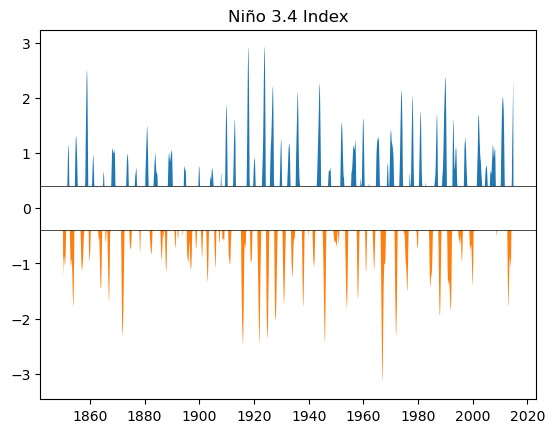

In [7]:
fig, ax = plt.subplots(1,1)

plt.axhline(y=0.4, color='black', linestyle='-', linewidth=.5)
plt.axhline(y=-0.4, color='black', linestyle='-', linewidth=.5)

plt.fill_between(enso_index["time"], enso_index["tos_gt_04"].data, 0.4)
plt.fill_between(enso_index["time"], enso_index["tos_lt_04"].data, -0.4)

plt.title('Niño 3.4 Index')
plt.savefig("enso.pdf", bbox_inches="tight")